<a href="https://colab.research.google.com/github/chengning-zhang/Intern-SWIB/blob/master/Week1_build_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [0]:
!pip install shap

In [0]:
import pandas as pd
from patsy import dmatrix
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import shap

In [0]:
def load_basic_data(fileName):

        tempDF = pd.read_parquet(fileName)
        
        tempDF['date'] = pd.to_datetime(tempDF['date'])
                    
        returnDF = tempDF.pivot(index='date', columns='sedol', values='d_return')

        returnDF.sort_index()

        returnDF.index = pd.to_datetime(returnDF.index)

        priceDF = tempDF.pivot(index='date', columns='sedol', values='LAST_PRICE')

        priceDF.sort_index()

        priceDF.index = pd.to_datetime(priceDF.index)  


        sectorDF = tempDF.pivot(index='date', columns='sedol', values='sector')

        sectorDF.sort_index()

        sectorDF.index = pd.to_datetime(sectorDF.index)  


        dollarVolumeDF = tempDF.pivot(index='date', columns='sedol', values='dollarVolume')

        dollarVolumeDF.sort_index()

        dollarVolumeDF.index = pd.to_datetime(dollarVolumeDF.index)

        return tempDF, returnDF, priceDF, sectorDF,dollarVolumeDF

tempDF, returnDF, priceDF, sectorDF,dollarVolumeDF = load_basic_data("/content/drive/My Drive/SWIB Quant Intern/SP500.pq")

In [28]:
tempDF[ tempDF['sedol'] == '2001692']

,date,sedol,sector,mktcap,d_return,LAST_PRICE,VOLUME_AVG_30D,dollarVolume
0,2001-09-17,2001692,Industrials,2779.3441,-0.393939,18.00,1331822.8,2.397281e+07
500,2001-09-18,2001692,Industrials,3088.1601,0.111111,20.00,1608904.4,3.217809e+07
999,2001-09-19,2001692,Industrials,3088.1601,0.000000,20.00,1826543.5,3.653087e+07
1498,2001-09-20,2001692,Industrials,2848.8278,-0.077500,18.45,1931604.4,3.563810e+07
1997,2001-09-21,2001692,Industrials,2763.9032,-0.029810,17.90,2140913.0,3.832234e+07
...,...,...,...,...,...,...,...,...
190000,2003-03-07,2001692,Industrials,438.3400,0.097700,2.81,2924500.0,8.217845e+06
190500,2003-03-10,2001692,Industrials,375.9400,-0.142300,2.41,2697686.5,6.501424e+06
191000,2003-03-11,2001692,Industrials,248.0300,-0.340200,1.59,3179443.4,5.055315e+06
191500,2003-03-12,2001692,Industrials,219.9500,-0.113200,1.41,3717969.7,5.242337e+06


dollarvolumn from price* volumn

In [0]:
1608904.4* 20

32178088.0

d_return is calculated from Last_price

In [0]:
# 0.1111
# (20 -18) /18

# -0.0775
(18.45 -20)/20

-0.07750000000000004

# Build Signals



 Notes from Roger:
1. build those signals based on price, return, volume, volatility, momentum

2. Use monthly data to remove noise.



For each stock_i where $i \in \{ 1,...1069\}$. we convert daily data to monthly data in order to remove noise. We group daily data by year_month. Suppose month T is the current month.

1 Volumn, The original daily data has VOLUME_AVG_30D, I use the VOLUME_AVG_30D_T.iloc[-1] of that month to represent that month's volume.

2 Volatility, use std as measure of volatility: std(Price_T).
Could do Beta later. 

3 mom1m, 1 month cumulative return, (Price_T.iloc[-1] - Price_T.iloc[0])/ Price_T.iloc[0].

4 momentum,  Price_T.iloc[-1] - Price_T.iloc[0], that month's last price - that month's first price

5 log makcap, use that month's average mktcap then take nature log: 
log(mean(mktcap_T))

6 # Price, use last day of that month's price: Price_T.iloc[-1]. 
since it recovers dollarvolume. Price's scale vary across different stocks, should be standardized.

7 Dollarvolume,  dollarVolume_T.iloc[-1]. 

8 Year_month T. 2001-09: T = 1, .... 2020-06: T = 226

9 Y, next month return: (Price_T+1.iloc[-1] - Price_T.iloc[-1]) / Price_T.iloc[-1]




In [0]:
# Map 2001-09 - 2020-06 to T 0 - ?
T = pd.to_datetime(tempDF['date']).dt.to_period('M').unique()
T = dict(zip (T,np.arange(len(T))))

In [0]:
# stock id, total of 1069 stocks 

stock_id = list(tempDF.sedol.unique()) 

stock_month = pd.DataFrame({'year_month':[],	'sedol':[],	'sector':[],	'volume':[],	'volatility':[],	'mom1m':[],	'momentum':[],	'log_mktcap':[],	
                            'LAST_PRICE':[],	'dollarVolume':[],	'next_month_return':[]})

# for stock i
for i in np.arange(len(stock_id)):
    stock_i = tempDF[tempDF['sedol'] == stock_id[i]]
    stock_i_sector = stock_i['sector'].unique()
    #if len(stock_i_sector) > 1:
    print(i)
    # for stock i, the time period
    stock_i['year_month'] = pd.to_datetime(stock_i['date']).dt.to_period('M')
    time_i = list(stock_i['year_month'].unique())
    # make monthly signals 
    # 1 volumn, 2 volatility , 3 momentum ,4 mom1m 5 log makcap, 6 price 7 dollarvolume

    # intitial new df
    stock_i_month = pd.DataFrame(data = {"year_month":time_i})

    # stock id and sector
    stock_i_month['sedol'] = stock_id[i]; stock_i_month['sector'] = stock_i_sector[-1]

    # Since it is VOLUME_AVG_30D, I use the .iloc[-1] of that month to represent that month's volume.
    stock_i_month['volume'] = [stock_i[stock_i['year_month'] == str(time)]['VOLUME_AVG_30D'].iloc[-1] for time in time_i]
    # use std as measure of volatility. Could do Beta later
    stock_i_month['volatility'] = [np.std( np.array(stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE']) ) for time in time_i]
    # mom1m, 1 month cumalative return, (.iloc[-1] - .iloc[0])/ .iloc[0]
    stock_i_month['mom1m'] = [( stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[-1] - 
      stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[0] ) /
      stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[0]
    for time in time_i]
    # momentum (.iloc[-1] - .iloc[0]), that month's last price - that month's first price
    stock_i_month['momentum'] = [stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[-1] - 
      stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[0] for time in time_i]
    # log makcap, use that month's average mktcap then take nature log
    stock_i_month['log_mktcap'] = [np.log(np.mean( np.array(stock_i[stock_i['year_month'] == str(time)]['mktcap']) ) ) for time in time_i]
    # price, use last day of that month's price, since it recovers dollarvolumn
    stock_i_month['LAST_PRICE'] = [stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[-1]  for time in time_i]
    # dollarvolume = price * volumn
    stock_i_month['dollarVolume'] = [stock_i[stock_i['year_month'] == str(time)]['dollarVolume'].iloc[-1]  for time in time_i]


    # Y, next month return(t+1), use (t+1.iloc[-1] - t.iloc[-1]) / t.iloc[-1]
    stock_i_month['next_month_return'] = np.concatenate( ( [ (stock_i[stock_i['year_month'] == str(time_i[t+1])]['LAST_PRICE'].iloc[-1] -  
                                          stock_i[stock_i['year_month'] == str(time_i[t])]['LAST_PRICE'].iloc[-1] )/
                                          stock_i[stock_i['year_month'] == str(time_i[t])]['LAST_PRICE'].iloc[-1]
                                          for t in np.arange(len(time_i)-1)] , [np.nan]) )
    
    # How many days available in that month
    stock_i_month['number_of_days'] = [len( stock_i[stock_i['year_month'] == str(time)].index  )  for time in time_i]

    # merge stock_i to previous DF
    stock_month = pd.concat([stock_month,stock_i_month])

    


# map T: 2001-06: 0,    2020-06 :226
stock_month['Month_T'] = stock_month['year_month'].map(T)

In [63]:
stock_month[stock_month['sedol'] == stock_id[1060]]

,year_month,sedol,sector,volume,volatility,mom1m,momentum,log_mktcap,LAST_PRICE,dollarVolume,next_month_return,number_of_days,Month_T
0,2020-04,BKLJ8V2,Industrials,4766823.7,0.941365,-0.009848,-0.13,8.566978,13.07,6.230239e+07,0.000765,21.0,223
1,2020-05,BKLJ8V2,Industrials,2928643.6,0.839318,0.043062,0.54,8.577716,13.08,3.830666e+07,0.311927,20.0,224
2,2020-06,BKLJ8V2,Industrials,2939142.8,1.304613,0.279642,3.75,8.789390,17.16,5.043569e+07,NaN,5.0,225


In [0]:
tempDF[tempDF['sedol'] == stock_id[1060]]

# Build Prediction Model

let $T \in \{1,2,....,226 \}$ denote the month index, 
let $ i \in \{1,2,....,1069 \}$ denote the stock index. 
The response variable is $\textbf{Next_month_return}$, denoted as $r_{i,T+1}$, of stock i and month T+1. 
The predictive characteristics are denoted as P-dimensional vector $z_{i,T}$, which includes 
$\{T,	sector,	log(mktcap),	Volume,	Volatility,	dollarVolume, mom1m, momentum\}$. Price and dollarVolume should be standardized later....
T is 1,2....226 following "citi-bank" paper, which measures the overal time trend for the macromarket.

1.  we consider regression problem, which means that the objective function is minimization of MSE. 

   $r_{i,T+1} = g(z_{i,T}) + \epsilon_{i,T+1}$
   
       

2.  we consider classification problem, for example a binary classification of whether d_return is positive or not. 
   
   $P(r_{i,T+1} > 0 | z_{i,T}) = g(z_{i,T})$

Following the paper(ML), The g function depends neither on i or T. By maintaining the same form over time and across different stocks, the model leverages information from the entire panel and every individual asset. Also g(.) depends on z only through $z_{i,T}$.


We split sample into 2 disjoint time periods, 2001-2013 as training, 2014-2020 as testing.

Regarding performance evaluation for regression, we use R square or MSE $R^2_{oos} = 1 - \frac{\sum_{(i,T)\in test}(r_{i,T+1}-\hat{r}_{i,T+1})^2}{\sum_{(i,T)\in test} r^2_{i,T+1}}$, 
and F1,accuracy for classification.






In [0]:
stock_month_dropna = stock_month.dropna()

In [62]:
stock_month_dropna

,year_month,sedol,sector,volume,volatility,mom1m,momentum,log_mktcap,LAST_PRICE,dollarVolume,next_month_return,number_of_days,Month_T
0,2001-09,2001692,Industrials,2605739.0,0.759132,0.063333,1.14,7.965820,19.14,4.987384e+07,-0.049112,10.0,0
1,2001-10,2001692,Industrials,1800316.5,1.004393,-0.085427,-1.70,8.040311,18.20,3.276576e+07,0.173626,23.0,1
2,2001-11,2001692,Industrials,2351187.0,1.456707,0.148387,2.76,8.005596,21.36,5.022135e+07,0.044007,21.0,2
3,2001-12,2001692,Industrials,1609172.7,0.658752,0.064947,1.36,8.139449,22.30,3.588455e+07,0.118386,20.0,3
4,2002-01,2001692,Industrials,1856330.4,0.903392,0.137774,3.02,8.256207,24.94,4.629688e+07,0.046512,21.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2020-04,BM5M5Y3,Industrials,14137310.0,3.885616,0.298017,14.88,11.462369,64.81,9.162391e+08,-0.004475,19.0,223
1,2020-05,BM5M5Y3,Industrials,13173122.0,3.871943,0.055801,3.41,11.404913,64.52,8.499298e+08,0.117018,20.0,224
0,2020-05,B01SD70,Consumer Discretionary,1226021.9,7.170124,0.020903,7.90,9.590333,385.84,4.730483e+08,-0.024440,13.0,224
0,2020-05,B0796X4,Health Care,2609637.2,18.389810,-0.079090,-32.49,10.505667,378.31,9.872518e+08,-0.036531,13.0,224


In [0]:
stock_month_dropna[stock_month_dropna['sedol'] == stock_id[1060]]

In [0]:
formula = 'C(sector) + volume	+volatility + mom1m +	momentum + log_mktcap+ dollarVolume + Month_T	+ LAST_PRICE ' 
#formula = 'volatility + mom1m +	momentum + log_mktcap+ Month_T	+ LAST_PRICE' # I have tried some combination, not good

# print(formula)
X = dmatrix(formula, stock_month_dropna,return_type= 'dataframe')
# X['time'] = X['time'].astype(int)
Y = stock_month_dropna.next_month_return

random forest regression

In [88]:
regr = RandomForestRegressor(max_depth=3,random_state=0)
regr.fit(X, Y)
regr.score(X,Y)

0.10534524006918755

random forest classifcatio 

In [0]:
# Y to binary 
def pos_ind(a):
  return 1 if a > 0 else 0 
Y_bi = [pos_ind(ele) for ele in Y]
# split sample 
# Y_tr = Y_bi[0:len(X_tr)]; Y_te = Y_bi[len(X_tr):]

In [81]:
clf = RandomForestClassifier(max_depth= 3,random_state=0)
clf.fit(X, Y_bi)
clf.score(X,Y_bi)
#0.5615907576094201

0.5606220839813375

Logistic Regression

In [83]:
clf2 = LogisticRegression(random_state=0).fit(X, Y_bi)
clf2.score(X,Y_bi)

0.5543923572539435

The Classification accuracy is little better than random guess, the problem is still feature engineering, how do we build better signals? My though is standardization.

# SHAP

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


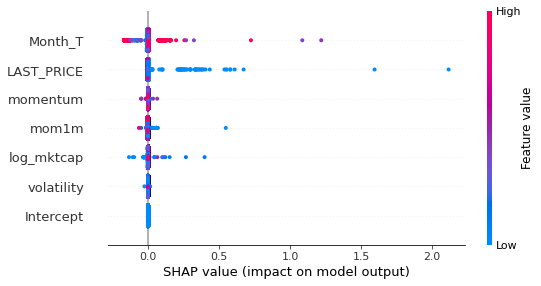

In [89]:
explainer = shap.TreeExplainer(regr)
shap_values2 = explainer.shap_values(X)

shap.summary_plot(shap_values2, X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


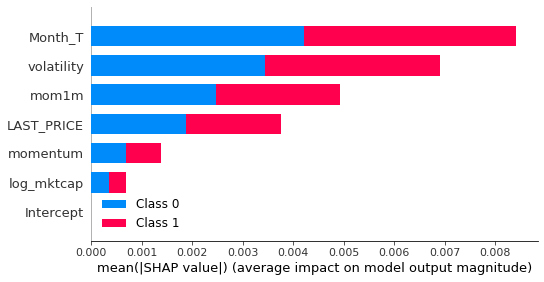

In [87]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

# Others

In [3]:
# stock id, total of 1069 stocks 

stock_id = list(tempDF.sedol.unique()) 

# for stock i
i = 3
stock_i = tempDF[tempDF['sedol'] == stock_id[i]]
stock_i_sector = stock_i['sector'].unique() # can be 2, NA + sector
if len(stock_i_sector) > 1:
  print(i)
# for stock i, the time period
stock_i['year_month'] = pd.to_datetime(stock_i['date']).dt.to_period('M')
time_i = list(stock_i['year_month'].unique())
# make monthly signals 
# 1 volumn, 2 volatility , 3 momentum ,4 mom1m 5 log makcap, 6 price 7 dollarvolume

# intitial new df
stock_i_month = pd.DataFrame(data = {"year_month":time_i})

# stock id and sector
stock_i_month.loc[:,'sedol'] = stock_id[i]; stock_i_month.loc[:,'sector'] = stock_i_sector[-1]

# Since it is VOLUME_AVG_30D, I use the .iloc[-1] of that month to represent that month's volume.
stock_i_month.loc[:,'volume'] = [stock_i[stock_i['year_month'] == str(time)]['VOLUME_AVG_30D'].iloc[-1] for time in time_i]
# use std as measure of volatility. Could do Beta later
stock_i_month.loc[:,'volatility'] = [np.std( np.array(stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE']) ) for time in time_i]
# mom1m, 1 month cumalative return, (.iloc[-1] - .iloc[0])/ .iloc[0]
stock_i_month.loc[:,'mom1m'] = [( stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[-1] - 
  stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[0] ) /
  stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[0]
 for time in time_i]
# momentum (.iloc[-1] - .iloc[0]), that month's last price - that month's first price
stock_i_month.loc[:,'momentum'] = [stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[-1] - 
  stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[0] for time in time_i]
# log makcap, use that month's average mktcap then take nature log
stock_i_month.loc[:,'log_mktcap'] = [np.log(np.mean( np.array(stock_i[stock_i['year_month'] == str(time)]['mktcap']) ) ) for time in time_i]
# price, use last day of that month's price, since it recovers dollarvolumn
stock_i_month.loc[:,'LAST_PRICE'] = [stock_i[stock_i['year_month'] == str(time)]['LAST_PRICE'].iloc[-1]  for time in time_i]
# dollarvolume = price * volumn
stock_i_month.loc[:,'dollarVolume'] = [stock_i[stock_i['year_month'] == str(time)]['dollarVolume'].iloc[-1]  for time in time_i]


# Y, next month return(t+1), use (t+1.iloc[-1] - t.iloc[-1]) / t.iloc[-1]
stock_i_month.loc[:,'next_month_return'] = np.concatenate( ( [ (stock_i[stock_i['year_month'] == str(time_i[t+1])]['LAST_PRICE'].iloc[-1] -  
                                      stock_i[stock_i['year_month'] == str(time_i[t])]['LAST_PRICE'].iloc[-1] )/
                                      stock_i[stock_i['year_month'] == str(time_i[t])]['LAST_PRICE'].iloc[-1]
                                      for t in np.arange(len(time_i)-1)] , [np.nan]) )



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
